# Exploring Ensemble Methods

In [163]:
import graphlab
import pandas as pd
import numpy as np
from __future__ import division

# Load LendingClub dataset

In [164]:
loans = graphlab.SFrame("E:\\Machine Learning\\U.W\\Classification\\lending-club-data.gl/")
loans.save("E:\\Machine Learning\\U.W\\Classification\\lending-club-data.csv", format="csv")
loans = pd.read_csv("E:\\Machine Learning\\U.W\\Classification\\lending-club-data.csv")

In [165]:
loans.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'is_inc_v', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans',
       'bad_loans', 'emp_length_num', 'grade_num', '

## Modifying the target column

In [166]:
loans["safe_loans"] = loans["bad_loans"].apply(lambda x: +1 if x==0 else -1)
loans = loans.drop(["bad_loans"], axis=1)

## Selecting features

In [167]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

In [168]:
loans_all = loans[[target] + features]
loans_without_na = loans_all.dropna(axis=0, how="any")
loans_with_na = loans_all[loans_all.isnull().any(axis=1)]

print "Droppping %s observations: keeping %s " % (len(loans_with_na), len(loans_without_na))

Droppping 29 observations: keeping 122578 


## Make sure the classes are balanced

In [169]:
safe_loans_raw = loans_without_na[loans_without_na[target] == 1]
risky_loans_raw = loans_without_na[loans_without_na[target] == -1]

percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(frac=percentage, random_state=42)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans            :", len(safe_loans)/float(len(loans_data))
print "Percentage of risky loans           :", len(risky_loans)/float(len(loans_data))
print "Total number of loans in our dataset:", len(loans_data)

Percentage of safe loans            : 0.5
Percentage of risky loans           : 0.5
Total number of loans in our dataset: 46294


In [186]:
one_hot_grade = pd.get_dummies(loans_data["grade"], prefix="grade")
one_hot_ownership = pd.get_dummies(loans_data["home_ownership"], prefix="ownership")
one_hot_purpose = pd.get_dummies(loans_data["purpose"], prefix="purpose")

features_label = [
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'dti',                       # debt to income ratio
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

loans_data_label = pd.concat([loans_data[features_label], one_hot_grade, one_hot_ownership, one_hot_purpose, loans_data[target]], axis=1)

## Split data into training and validation sets

In [187]:
from sklearn.model_selection import train_test_split

In [188]:
train_data, validation_data = train_test_split(loans_data_label, test_size=0.2, random_state=42)

In [189]:
print len(train_data)/len(loans_data)
print len(validation_data)/len(loans_data)
print len(train_data)
print len(validation_data)

0.799995679786
0.200004320214
37035
9259


# Gradient boosted tree classifier

In [190]:
from sklearn.ensemble import AdaBoostClassifier

In [191]:
train_data.columns.values

array(['sub_grade_num', 'short_emp', 'emp_length_num', 'dti',
       'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero',
       'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none',
       'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util',
       'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc',
       'funded_amnt', 'funded_amnt_inv', 'installment', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'ownership_MORTGAGE', 'ownership_OTHER', 'ownership_OWN',
       'ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'safe_loans'], dtype=object)

In [206]:
clf = AdaBoostClassifier(n_estimators = 5)
model_5 = clf.fit(train_data.drop(target, axis=1), train_data[target])

# Making predictions

In [207]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,safe_loans
119106,0.2,0,11,9.26,7.67478,2.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
7298,1.0,0,2,12.05,1.99263,1.0,0.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0,1
98062,0.2,0,4,18.48,9.66270,2.0,0.0,2.0,0,1,...,0,0,0,0,0,0,0,0,1,-1
12679,1.0,0,11,8.31,3.76766,0.0,1.0,1.0,1,1,...,1,0,0,0,0,0,0,0,0,-1


### Predicting on sample validation data

In [209]:
model_5.predict(sample_validation_data.drop(["safe_loans"], axis=1))

array([-1,  1, -1, -1], dtype=int64)

### Prediction probabilities

In [213]:
model_5.predict_proba(sample_validation_data.drop(["safe_loans"], axis=1))[:, 1]

array([0.49569827, 0.54590972, 0.47792678, 0.49569827])

## Evaluating the model on the validation data

In [222]:
predictions = model_5.predict(validation_data.drop(["safe_loans"], axis=1))
accuracy = (predictions==validation_data["safe_loans"]).sum() / float(len(validation_data))

print accuracy

0.6253375094502646


In [223]:
validation_data["predict"] = model_5.predict(validation_data.drop(["safe_loans"], axis=1))

c:\python27\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [225]:
false_positives = len(validation_data[(validation_data["predict"]==1) & (validation_data["safe_loans"]==-1)])
false_negatives = len(validation_data[(validation_data["predict"]==-1) & (validation_data["safe_loans"]==1)])

print false_positives
print false_negatives

1497
1972


## Comparison with decision trees

In [226]:
cost_of_mistakes = 10000 * false_negatives + 20000 * false_positives

cost_of_mistakes

49660000

## Most positive & negative loans.

In [230]:
validation_data["predict_prob"] = model_5.predict_proba(validation_data.drop(["safe_loans", "predict"], axis=1))[:, 1]

c:\python27\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [249]:
validation_data[["grade_A", "grade_B", "grade_C", "grade_D", "grade_E", 
                 "grade_F", "grade_G", "predict"]].sort_values(by=["predict"], ascending=False)[0:5]

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,predict
95297,1,0,0,0,0,0,0,1
87648,1,0,0,0,0,0,0,1
8764,0,1,0,0,0,0,0,1
91791,1,0,0,0,0,0,0,1
17710,0,1,0,0,0,0,0,1


In [250]:
validation_data[["grade_A", "grade_B", "grade_C", "grade_D", "grade_E",
                 "grade_F", "grade_G", "predict"]].sort_values(by=["predict"], ascending=True)[0:5]

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,predict
98062,0,0,0,1,0,0,0,-1
96608,0,0,0,1,0,0,0,-1
54423,0,0,1,0,0,0,0,-1
7013,0,0,1,0,0,0,0,-1
86153,0,0,1,0,0,0,0,-1


## Effect of adding more trees

In [252]:
clf = AdaBoostClassifier(n_estimators = 10)
model_10 = clf.fit(train_data.drop(target, axis=1), train_data[target])

In [253]:
clf = AdaBoostClassifier(n_estimators = 50)
model_50 = clf.fit(train_data.drop(target, axis=1), train_data[target])

In [254]:
clf = AdaBoostClassifier(n_estimators = 100)
model_100 = clf.fit(train_data.drop(target, axis=1), train_data[target])

In [255]:
clf = AdaBoostClassifier(n_estimators = 200)
model_200 = clf.fit(train_data.drop(target, axis=1), train_data[target])

In [256]:
clf = AdaBoostClassifier(n_estimators = 500)
model_500 = clf.fit(train_data.drop(target, axis=1), train_data[target])

## Compare accuracy on entire validation set

In [281]:
validation_data.columns.values

array(['sub_grade_num', 'short_emp', 'emp_length_num', 'dti',
       'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero',
       'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none',
       'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util',
       'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc',
       'funded_amnt', 'funded_amnt_inv', 'installment', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'ownership_MORTGAGE', 'ownership_OTHER', 'ownership_OWN',
       'ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'safe_loans', 'predict',
       'predict_prob'], dtype=object)

In [290]:
validation_accuracy_10 = (model_10.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"], 
                        axis=1)) == validation_data["safe_loans"]).sum() / float(len(validation_data))

validation_accuracy_50 = (model_50.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"],
                        axis=1)) == validation_data["safe_loans"]).sum() / float(len(validation_data))

validation_accuracy_100 = (model_100.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"],
                          axis=1)) == validation_data["safe_loans"]).sum() / float(len(validation_data))

validation_accuracy_200 = (model_200.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"],
                            axis=1)) == validation_data["safe_loans"]).sum() / float(len(validation_data))

validation_accuracy_500 = (model_500.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"],
                            axis=1)) == validation_data["safe_loans"]).sum() / float(len(validation_data))

In [291]:
print validation_accuracy_10
print validation_accuracy_50
print validation_accuracy_100
print validation_accuracy_200
print validation_accuracy_500

0.6459660870504375
0.6563343773625662
0.6641105950966627
0.6665946646506102
0.6701587644454045


## Plot the training and validation error vs. number of trees

In [292]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams["figure.figsize"] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={"size":15})
    plt.rcParams.update({"font.size": 16})
    plt.tight_layout()

In [297]:
train_err_10 = (model_10.predict(train_data.drop(["safe_loans"], axis=1)) != train_data["safe_loans"]).sum() / float(len(train_data))
train_err_50 = (model_50.predict(train_data.drop(["safe_loans"], axis=1)) != train_data["safe_loans"]).sum() / float(len(train_data))
train_err_100 = (model_100.predict(train_data.drop(["safe_loans"], axis=1)) != train_data["safe_loans"]).sum() / float(len(train_data))
train_err_200 = (model_200.predict(train_data.drop(["safe_loans"], axis=1)) != train_data["safe_loans"]).sum() / float(len(train_data))
train_err_500 = (model_500.predict(train_data.drop(["safe_loans"], axis=1)) != train_data["safe_loans"]).sum() / float(len(train_data))

In [298]:
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

print training_errors

[0.34837316052382883, 0.33357634669906844, 0.32812204671256917, 0.32104765762116916, 0.31238018090995007]


In [300]:
validation_err_10 = (model_10.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"], 
                            axis=1)) != validation_data["safe_loans"]).sum() / float(len(validation_data))

validation_err_50 = (model_50.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"], 
                            axis=1)) != validation_data["safe_loans"]).sum() / float(len(validation_data))

validation_err_100 = (model_100.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"], 
                            axis=1)) != validation_data["safe_loans"]).sum() / float(len(validation_data))

validation_err_200 = (model_200.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"], 
                            axis=1)) != validation_data["safe_loans"]).sum() / float(len(validation_data))

validation_err_500 = (model_500.predict(validation_data.drop(["safe_loans", "predict", "predict_prob"], 
                            axis=1)) != validation_data["safe_loans"]).sum() / float(len(validation_data))

In [301]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

print validation_errors

[0.3540339129495626, 0.34366562263743383, 0.3358894049033373, 0.33340533534938976, 0.32984123555459555]


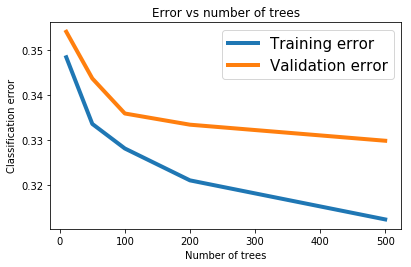

In [302]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label="Training error")
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label="Validation error")

make_figure(dim=(10,5), title="Error vs number of trees",
           xlabel="Number of trees",
           ylabel="Classification error",
           legend="best")